# Solve the discretized 1D linear convection equation with periodic boundary condition

The linear convection equation
$$
    \partial_t u + c \partial_x u = D \partial_{xx} u + S u
$$
can be discretized, yielding
$$
    \partial_t u + A u = 0.
$$
$A$ can be decomposed as
$$
    A = H_1+i H_2,
$$
where
$$
    H_1 = \dfrac{A+A^\dagger}{2} \;\mathrm{and}\; H_2 = \dfrac{A-A^\dagger}{2i}.
$$
Then
$$
    \partial_t u + H_1 u + i H_2 u = 0.
$$
Employ the warp transform
$$
    w(x,y,t) = e^{-y}u(x,t), \; y>0.
$$
We have
$$
    \partial_t w - H_1 \partial_y w + i H_2 w = 0.
$$
Fourier transform $\tilde{w} = \mathcal{F}_y[w]$
yields
$$
    \partial_t \tilde{w} + i k_y H_1 \tilde{w} + i H_2 \tilde{w} = 0
$$

For the linear convection equation with the inlet boundary condition at LHS, discretized using the central scheme
$$
    \partial_t \bm{u} + \bm{A} \bm{u} + \bm{b} = 0,
$$

Define
$$
\tilde{\bm{u}} = \begin{bmatrix} \bm{u} \\ v \end{bmatrix}
$$
where $v(t)=1$.
The discretized equation becomes
$$
    \partial_t \tilde{\bm{u}} + \tilde{\bm{A}} \tilde{\bm{u}} = 0,
$$
with
$$
    \tilde{\bm{A}} =
    \begin{bmatrix}
    \bm{A} & \bm{b} \\
    \bm{0} & 0 \\
    \end{bmatrix}
$$

### Fourier transform

QFT has
$$
    y[k] = \sum x[n] e^{i2\pi kn}
$$

DFT has
$$
    y[k] = \sum x[n] e^{-2i\pi kn}
$$

In [43]:
import numpy as np
from scipy import fft, special
from scipy.linalg import expm, eig
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit.compiler import transpile
from qiskit.quantum_info import Operator, state_fidelity
from qiskit.circuit.library import QFT
from pyutils import fig

## Backend

statevector_simulator

In [44]:
backend = Aer.get_backend('statevector_simulator')

## Timestep and Grids

$N = 2^{n}$

In [45]:
C = 10
D = 0.5
S = -1

# timestep
time = np.linspace(0, 2, num=21)

# number of qubits for u
nqu = 8
q_u = QuantumRegister(nqu, name='qu')
nx = 2**nqu

# number of qubits for v
nqv = 12
ny = 2**nqv

results = np.zeros((nx, time.size))

## Initialization

In [46]:
L = 30

## nx
# Initialization
x = np.linspace(-L/2, L/2, num=nx, endpoint=False)

dx = L / nx

sigma = np.sqrt(1/2)
mu = -10
g = np.exp(-np.square(x-mu))

for i, v in enumerate(g):
    if np.abs(x[i] - mu) > 5*sigma:
        g[i] = 0

u_init = g

u_init_norm = np.sqrt(np.sum(np.square(u_init)))

u0 = u_init / u_init_norm

$$e^{-\alpha\lvert y\rvert}$$

In [47]:
shift = 0
alpha = 10
bzone = 0
wy = 8
y = np.linspace(-np.pi*(wy/2+shift), np.pi*(wy/2-shift), num=ny, endpoint=False)

bottom = np.exp(-np.pi*(wy/2-shift))

v_init = np.zeros(ny)
for i, vy in enumerate(y):
    if vy < -np.pi*(wy/2+shift-bzone) or vy > np.pi*(wy/2-shift-bzone):
        v_init[i] = 0
    elif vy < - np.pi * shift :
        tmp = np.exp(alpha*(vy+shift*(1+1/alpha)*np.pi))
        if tmp < bottom :
            tmp = bottom
        v_init[i] = tmp
    else:
        v_init[i] = np.exp(-vy)

v_init0 = np.zeros(ny)
v_init0[:int(ny/2)] = np.exp(y[:int(ny/2)])
v_init0[int(ny/2):] = np.exp(-y[int(ny/2):])
 
fv = fft.fft(v_init, norm='forward')
kv = fft.fftfreq(ny)*ny*2/wy

Text(0, 0.5, '$v(y)$')

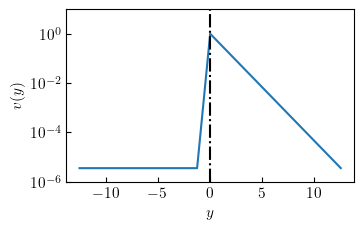

In [48]:
pc = fig.PlotConfig(subplot_ratio=0.6)

figure, ax = pc.get_simple()

ax.semilogy(y, v_init)
ax.plot([0, 0], [1e-6, 1e1], '-.k')
ax.set_ylim([1e-6, 1e1])
ax.set_xlabel('$y$')
ax.set_ylabel('$v(y)$')

## Discretized matrix

### Convection, central difference scheme with left inlet

$2^n$ points

$$
    \bm{A} = 
    \dfrac{c}{2\Delta x}
    \begin{bmatrix}
    0  & 1 &   & & -1 \\
    -1 & 0 & 1 & & \\
       & \ddots & \ddots & \ddots & \\
       & & -1 & 0 & 1 \\
    1  & & & -1 & 0
    \end{bmatrix}.
$$

In [49]:
AC = np.zeros((nx, nx))
for i in range(nx-1):
    AC[i,i+1] = 1
    AC[i+1,i] = -1
AC[0,-1] = -1
AC[-1,0] = 1
AC = AC * C / (2*dx)

### Diffusion, central difference scheme

$2^n$ points

$$
    \bm{A} = 
    \dfrac{D}{\Delta x^2}
    \begin{bmatrix}
    2  & -1 &   & & -1 \\
    -1 & 2 & -1 & &   \\
       & \ddots & \ddots & \ddots & \\
       & & -1 & 2 & -1 \\
    -1 & & & -1 & 2  \\
    \end{bmatrix}.
$$

In [50]:
AD = np.zeros((nx, nx))
for i in range(nx-1):
    AD[i,i+1] = -1
    AD[i+1,i] = -1
    AD[i,i] = 2
AD[-1,-1] = 2
AD[0,-1] = -1
AD[-1,0] = -1
AD = AD * D / np.square(dx)

### Reaction

In [51]:
AS = np.eye(nx)
AS *= -S

In [52]:
A = AC + AD + AS

In [53]:
A = np.matrix(A)
AH = A.H
H1 = (A+AH)/2
H2 = (A-AH)/2

## Simulation circuit

In [54]:
for j, t in enumerate(time):

    states = []

    for i, k in enumerate(kv):

        # initialization
        circ_init_u = QuantumCircuit(q_u, name='Init_u')
        circ_init_u.initialize(u0*fv[i]/np.abs(fv[i]), q_u)
        circ_init_u_inst = circ_init_u.to_instruction()

        qc = QuantumCircuit(q_u)
        qc.append(circ_init_u_inst, q_u)
        qc.barrier()

        M = 1.j*k*H1 - H2
        U = expm(M*t)
        qc.append(Operator(U), q_u)

        job = backend.run(transpile(qc, backend))
        state = job.result().get_statevector(qc)
        states.append(state)

    soln = np.zeros(nx, dtype='complex128')

    for i, k in enumerate(kv):
        soln += states[i].data * np.abs(fv[i]) * np.exp(1.j*np.pi*k*wy/2)

    soln *= u_init_norm
    soln *= np.exp(y[ny//2])

    results[:,j] = soln.real

## Plot

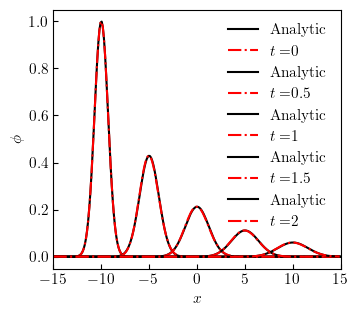

In [ ]:
pc = fig.PlotConfig()

figure, ax = pc.get_simple()

#ax.plot(x, u_init, '-.b', label='$t=0.0$')

#ax.plot(x, soln.real, '--r', label='$t=2.0$ Quantum')

for i in range(0,5):

    t = time[5*i]

    ut = np.exp(-np.square(x-mu-C*t)/(1+4*D*t)) / np.sqrt(1+4*D*t) * np.exp(S*t)
    ax.plot(x, ut, '-k', label = 'Analytic')

    ax.plot(x, results[:,5*i], '-.r', label='$t=${:g}'.format(t))

ax.legend(frameon=False, loc='upper right')

ax.set_xlabel('$x$')
ax.set_ylabel('$\phi$')

ax.set_xlim([-L/2, L/2])

ax.set_xticks(np.linspace(-L/2, L/2, num=7))

In [ ]:
np.savez('1DPeriodicDiscretizedSeparateC{:g}D{:g}S{:g}L{:g}nx{:g}wy{:g}ny{:g}'.format(C,D,S,L,nqu,wy,nqv), 
         x = x, t = time, y = results)